In [2]:
# Librerías para tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Librerías para calcular el tamaño muestral
# -----------------------------------------------------------------------
from statsmodels.stats.power import NormalIndPower
import statsmodels.stats.api as sms


# Librerías para visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para pruebas estadísticas
# -----------------------------------------------------------------------
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest # para hacer el ztest

# Importamos las funciones del archivo de soporte
# ------------------------------------------------------------------------------
from src import soporte_abtesting as sa


# Otros recursos
# ------------------------------------------------------------------------------
import math

# Configuración de las gráficas
# ------------------------------------------------------------------------------
# establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_style("dark")

# cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
sns.set_theme(style="dark")

# establece el estilo en seaborn-v0_8-darkgrid. 
plt.style.use('dark_background')

# Descripción del problema

Una empresa de juegos ha creado un modo de juego nuevo que quiere añadir al modo de juego actual. La empresa espera que el nuevo modo de juego aumente la tasa de retención de los usuarios en 1 día del 32% actual al 35%.  
El dataset presenta las siguientes columnas:  
- `user_id`: id de cada usuario  
- `version`: versión del modo de juego que tiene cada usuario; "current" será el grupo control y "new" el grupo test.  
- `retention_day1`: valor booleano que indica si el usuario vuelve a jugar en 1 día o no.  

Con los datos que tenemos en el dataset, planteamos las siguientes hipótesis:

- $H0$: No hay diferencia en la tasa de retención en un día entre el modo de juego actual y el modo nuevo. 

- $H1$: La tasa de retención en 1 día es más alta en el modo nuevo.

Para este problema estamos interesados en capturar es la tasa de retención. En este caso, esta información la tenemos en el conjunto de datos en la columna "retencion_day1", donde: 

- False: El usuario no volvió a jugar en 1 día.
- True: El usuario volvió a jugar en 1 día.

Teniendo esta información y los valores de retención actual y esperada, calculamos el tamaño muestral que necesitamos.

In [3]:
# calculamos la diferencia esperada entre las tasas de conversión del modo actual (32%) y el nuevo (35%), que es una medida estandarizada de la diferencia entre dos proporciones.
diferencia = sms.proportion_effectsize(0.32, 0.35) 

tamaño_muestral = sms.NormalIndPower().solve_power(
    diferencia,  # el tamaño del efecto calculado en el paso anterior
    power=0.8, # la potencia estadística deseada, que recordemos se suele establecer en 0.8
    alpha=0.05, # nivel de significancia deseado, que normalmente se establece en 0.05
    ratio=1 # La relación entre el tamaño de muestra del grupo experimental y el tamaño de muestra del grupo de control. En este caso, se establece en 1, lo que significa que ambos grupos tendrán el mismo tamaño de muestra.
    )   
print(f'El tamaño muestral debe de ser de: {math.ceil(tamaño_muestral)}')           

El tamaño muestral debe de ser de: 3884


Hemos obtenido un tamaño muestral de 3884 usuarios para cada grupo, lo que implica un total de 7768 usuarios.

## Análisis del dataset

In [4]:
# Cargamos el dataset
df = pd.read_csv("data/ab_testing_dataset.csv", index_col=0)

In [5]:
df.head()

,user_id,version,return_day1
12808,38969,current,False
6912,99443,new,False
14165,77053,new,True
3579,75384,new,False
8227,44972,current,False


In [6]:
# Hacemos uso de una de nuestras funciones de soporte
sa.exploracion_dataframe(df, "version")

El número de datos es 35819 y el de columnas es 3

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 3778

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user_id,int64
version,object
return_day1,bool



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna VERSION tiene las siguientes valore únicos:


,count
version,
new,17910
current,17909



 ..................... 

Los principales estadísticos de las columnas categóricas para el CURRENT son: 


,count,unique,top,freq
version,17909,1,current,17909



 ..................... 

Los principales estadísticos de las columnas numéricas para el CURRENT son: 


,count,mean,std,min,25%,50%,75%,max
user_id,17909.0,29976.626054,11566.795152,10001.0,19873.0,29992.0,40010.0,49994.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el NEW son: 


,count,unique,top,freq
version,17910,1,new,17910



 ..................... 

Los principales estadísticos de las columnas numéricas para el NEW son: 


,count,mean,std,min,25%,50%,75%,max
user_id,17910.0,74993.100893,14421.207107,50000.0,62540.0,74903.0,87528.0,99993.0


In [7]:
# El análsis exploratorio muestra que el dataset tiene 3778 filas duplicadas, por lo que los eliminamos.
df.drop_duplicates(inplace=True)

In [8]:
# Después de eliminar las filas duplicadas, comprobamos si hay usuarios repetidos
print(f"Tenemos un total de {df.duplicated(subset='user_id').sum()} usuarios repetidos")

Tenemos un total de 2608 usuarios repetidos


In [9]:
# Como, en principio, tenemos suficientes datos para realizar el test, podemos eliminar los usurarios repetidos.
df.drop_duplicates(subset="user_id", inplace = True)

In [10]:
df.count()

user_id        29433
version        29433
return_day1    29433
dtype: int64

Tras eliminar todos los duplicados, nos quedan 29433 filas. Ahora podemos seleccionar los 3884 usuarios que necesitamos para cada grupo.

In [11]:
# seleccionamos 3884 usuarios de cada grupo de forma aleatoria
grupo_control = df[df['version'] == 'current'].sample(n=math.ceil(tamaño_muestral), random_state=22)
grupo_test = df[df['version'] == 'new'].sample(n=math.ceil(tamaño_muestral), random_state=22)

# unimos los dos conjuntos de datos
ab_test = pd.concat([grupo_control, grupo_test], axis=0).reset_index(drop = True)

# comprobamos que tengamos el mismo número de usuarios en los 2 grupos
ab_test["version"].value_counts()

version
current    3884
new        3884
Name: count, dtype: int64

           mean     std
version                
current  0.2783  0.4482
new      0.4367  0.4960


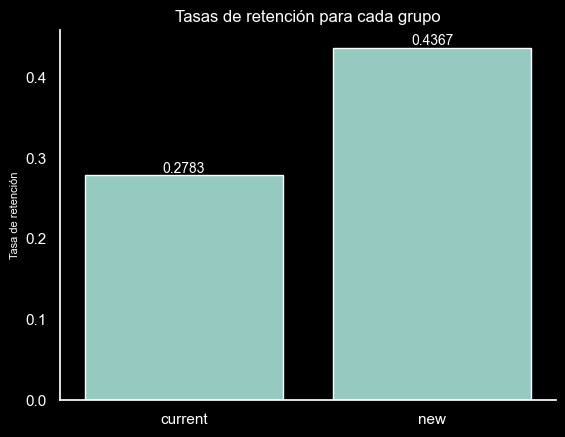

In [12]:
# vamos a empezar con algunas gráficas para ir familiarizandonos con los datos, 
# lo primero que vamos a hacer es calcular la tasa de retencion de cada uno de los grupos
tasa_retencion = ab_test.groupby('version')['return_day1'].agg(["mean", "std"]).round(4)
print(tasa_retencion)

fig = sns.barplot(tasa_retencion, 
                  x = tasa_retencion.index, 
                  y = "mean") 

# ponemos las etiquetas en cada una de las barras
fig.bar_label(fig.containers[0], fontsize=10)

# eliminar los ejes de arriba y la derecha
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)

# ponemos título a la gráfica
fig.set_title("Tasas de retención para cada grupo")

# cambiamos el nombre del eje y
fig.set_ylabel("Tasa de retención", fontsize = 8)

# quitamos el nombre del eje x
fig.set_xlabel("");

Para el grupo de control, la tasa de retención promedio es del 27.83 %, con una desviación estándar del 44,82%.  
Para el grupo test, la tasa de retención promedio es del 43,67%, con una desviación estándar del 49.6%.  
Esto sugiere que el el grupo test, tiene una tasa de retención promedio bastante más alta que el grupo de control, sin embargo, las desviaciones estándar muestran ligeramente mayor variabilidad en el grupo test, lo que podría implicar una mayor incertidumbre en el resultado.

## Pruebas paramétricas

Como estamos comparando medias de proporciones de 2 grupos independientes, en este caso la tasa de retención, aplicamos el Z-test.

In [13]:
# instanciamos la clase de los métodos estadísticos
ab_testing = sa.Pruebas_parametricas("version",  "return_day1", ab_test, "new", "current")
ab_testing.z_test()

El estadístico de prueba (Z) es: -14.56, el p-valor es 0.0
El p-valor de la prueba es 0.0, por lo tanto, hay diferencias significativas entre los grupos.


Dado el gráfico anterior, que mostraba que la tasa de rentención del grupo test es significativamente mayor que la del grupo control, unido al p-valor obtenido, se puede rechazar la hipótesis nula y concluimos que la nueva versión del juego consigue el objetivo de aumentar la tasa de retención.